<a href="https://colab.research.google.com/github/vitorbdiniz/python-applied-to-finance/blob/main/Performance_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Avaliando Performance De Portfólios

Hoje trazemos mais uma aplicação da linguagem de programação Python aplicada ao campo dos investimentos. Dessa vez, iremos aplicar as métricas de avaliação de performance trazidas pelo 19º capítulo da sequência de *e-books* do CFA Institute Investment Foundations®: [Performance Evaluation](https://www.cfainstitute.org/-/media/documents/support/programs/investment-foundations/19-performance-evaluation.ashx?la=en&hash=F7FF3085AAFADE241B73403142AAE0BB1250B311).

Com isso, iremos - abordando prática e teoria - entender os seguintes tópicos:

1. Cálculo de retornos absolutos;
2. Métricas de retornos ajustados ao risco;
3. Métricas de retornos relativos;
4. Cálculo de retorno anormal.


Se você ainda não conhece os comandos básicos do Python, é interessante ler os primeiros tópicos da série [Quant & Investimentos](https://tc.com.br/tc-school/quant-investimentos/).

#Importando bibliotecas

Inicialmente, importaremos as bibliotecas necessárias para o desenvolvimento deste estudo:

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt

from statistics import variance, mean, stdev
from statsmodels.api import OLS
from statsmodels.tools import add_constant

import pandas_datareader as web
import matplotlib.pyplot as plt

#Funções Úteis

Em seguida, declararemos as algumas funções úteis que usaremos durante o estudo.

In [ ]:
def retornos_mensais(meu_patrimonio):
  retornos = [0]
  for i in range(1, len(meu_patrimonio)):
    retornos.append(meu_patrimonio[i]/meu_patrimonio[i-1] -1)
  return np.array(retornos)

#Para quem deseja obter maior performance, sugere-se utilizar lambda expressions como:
retornos_mensais = lambda meu_patrimonio : np.array([0] + [meu_patrimonio[i]/meu_patrimonio[i-1] -1 for i in range(1, len(meu_patrimonio)) ])
#Esta função criada na linha 8 possui a mesma semântica daquela criada da forma padrão (utilizando 'def')

In [ ]:
def retornos_acumulados(retornos_mensais):
  capital = 1
  retornos = []
  for r in retornos_mensais:
    capital += capital*r
    retornos.append(capital-1)
  return retornos

In [ ]:
def retornos_com_aportes(meu_patrimonio, aporte):
  retornos = [0]
  for i in range(1, len(meu_patrimonio)):
    retornos.append((meu_patrimonio[i]-aporte) / meu_patrimonio[i-1] -1)
  return retornos

#Patrimônio, Benchmark e Selic

No decorrer deste estudo, utilizaremos constantemente esses dados. O patrimônio consiste no volume de dinheiro existente nas nossas carteiras (utilizaremos duas: um com aportes mensais e outro sem); o *benchmark* é o retorno do mercado, representado pelo Ibovespa; e a taxa básica de juros do Brasil, ou taxa Selic. Tais dados terão frequência mensal neste artigo.

Dessa forma, declararemos as variáveis de patrimônio e benchmark:

In [ ]:
#Declaração de um patrimônio fictício
patrimonio = pd.DataFrame({"mes":range(1, 13), "evolucao" : [100000.0, 112787.96, 121816.85, 132210.96, 144643.06, 138646.95, 128718.55, 128120.36, 145628.81, 157053.58, 153182.50, 148555.50]})
patrimonio_com_aportes = pd.DataFrame({"mes":range(1, 13), "evolucao" : [100000, 115355.94, 126432.02, 138439.70, 156719.23, 152143.25, 143935.61, 146125.70, 168232.67, 185967.01, 190168.15, 179810.12]})
ibov = web.get_data_yahoo("^BVSP", start="2020-03-01", end="2021-02-28")["Adj Close"].resample("M").pad()

A taxa Selic precisa de um processamento maior nos dados, pois a buscaremos através da API do Banco Central do Brasil e o formato de entrega é diferente do utilizado neste estudo.

In [ ]:
def reformata_datas(datas):
  """
    Reformata datas do padrão dd/mm/aaaa para o tipo datetime.date
    retorna lista de datetime.date
  """

  new_datas = []
  for data in datas:
    d = data.split("/")
    d = dt.datetime(int(d[2]), int(d[1]), int(d[0]))
    new_datas.append(d)
  return new_datas

In [ ]:
def retornos_mensais_selic(selic):
  """
    Calcula os retornos mensais da selic
    retorna lista de retornos
  """
  last_date = selic["data"].iloc[0]
  retornos = []
  selic_mensal = []

  for i in range(selic.shape[0]):
    if selic["data"].iloc[i].month == last_date.month:
      retornos.append(selic["valor"].iloc[i])
    else:
      last_date = selic["data"].iloc[i]
      selic_mensal.append(retornos_acumulados(retornos)[-1])
      retornos = []
  if retornos != []:
    selic_mensal.append(retornos_acumulados(retornos)[-1])
  return selic_mensal[1:len(selic_mensal)]

def busca_selic(inicio, fim):
  """
    Busca dados da SELIC
    Retorna lista de retornos mensais
  """
  url = f"http://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados?formato=csv&dataInicial={inicio}&dataFinal={fim}"
  selic = pd.read_csv(url, sep=";")
  selic["valor"] = [float(str(x).replace(",", "."))/100 for x in selic["valor"]]
  selic["data"] = reformata_datas(selic['data'])
  selic = np.array(retornos_mensais_selic(selic))
  return selic

In [ ]:
selic = busca_selic("01/03/2020", "28/02/2021")

# Cálculo de Retornos Absolutos

##Carteira Sem aportes

Suponha que o temos uma carteira de investimentos e que nosso patrimônio evoluiu da seguinte forma durante os últimos 12 meses:

In [ ]:
patrimonio

,mes,evolucao
0,1,100000.00
1,2,112787.96
2,3,121816.85
3,4,132210.96
4,5,144643.06
5,6,138646.95
6,7,128718.55
7,8,128120.36
8,9,145628.81
9,10,157053.58


Para calcular os retornos mensais absolutos de uma carteira, basta utilizar a equação:

**Retorno = patrimônio atual / patrimônio anterior -1**

Com isso, podemos calcular as rentabilidades mensais aplicando a função *retornos_mensais* (que implementa a fórmula acima).

In [ ]:
patrimonio["retornos"] = retornos_mensais(patrimonio["evolucao"])
patrimonio

,mes,evolucao,retornos
0,1,100000.00,0.000000
1,2,112787.96,0.127880
2,3,121816.85,0.080052
3,4,132210.96,0.085326
4,5,144643.06,0.094032
5,6,138646.95,-0.041455
6,7,128718.55,-0.071609
7,8,128120.36,-0.004647
8,9,145628.81,0.136656
9,10,157053.58,0.078451


Além disso, para verificar a rentabilidade acumulada do nosso patrimônio, iremos aplicar a fórmula do retorno considerando sempre o **patrimônio anterior** como o inicial (patrimônio do mês 1). Essa descrição está implementada na função *retornos_acumulados* e, ao aplicá-la, obtemos:

In [ ]:
patrimonio["acumulado"] = retornos_acumulados(patrimonio["retornos"])
patrimonio

,mes,evolucao,retornos,acumulado
0,1,100000.00,0.000000,0.000000
1,2,112787.96,0.127880,0.127880
2,3,121816.85,0.080052,0.218168
3,4,132210.96,0.085326,0.322110
4,5,144643.06,0.094032,0.446431
5,6,138646.95,-0.041455,0.386470
6,7,128718.55,-0.071609,0.287185
7,8,128120.36,-0.004647,0.281204
8,9,145628.81,0.136656,0.456288
9,10,157053.58,0.078451,0.570536


##Medição com aportes mensais

Para tornar o caso mais realista, iremos modificar nossa regra de aportes patrimônio para um aporte mensal de R$ 1000,00, sendo realizado após o cálculo da rentabilidade de cada mês. Agora, temos um patrimônio que obteve a seguinte evolução:

In [ ]:
patrimonio_com_aportes

,mes,evolucao
0,1,100000.00
1,2,115355.94
2,3,126432.02
3,4,138439.70
4,5,156719.23
5,6,152143.25
6,7,143935.61
7,8,146125.70
8,9,168232.67
9,10,185967.01


Se utilizarmos a função criada previamente para calcular os retornos, obteremos o seguinte resultado:

In [ ]:
print(f"O retorno acumulado dos últimos 12 meses é {retornos_acumulados(retornos_mensais(patrimonio_com_aportes['evolucao']))[-1]*100 : .2f}%")

O retorno acumulado dos últimos 12 meses é  79.81%


Contudo, obtivemos aqui um **resultado falso**, pois há o efeito do incremento de R$ 12 mil pela sucessão de aportes. Sabendo disso, deveremos, portanto, desconsiderar o valor do aporte do mês seguinte, conforme a equação:

**retorno = (patrimônio atual - aporte) / patrimônio anterior -1**

Tal equação está implementada na função *retornos_com_aportes*.

Aplicando a função, obtemos o seguintes resultados mensais:


In [ ]:
patrimonio_com_aportes["retornos"] = retornos_com_aportes(patrimonio_com_aportes["evolucao"], aporte=1000)
patrimonio_com_aportes

,mes,evolucao,retornos
0,1,100000.00,0.000000
1,2,115355.94,0.143559
2,3,126432.02,0.087348
3,4,138439.70,0.087064
4,5,156719.23,0.124816
5,6,152143.25,-0.035579
6,7,143935.61,-0.060520
7,8,146125.70,0.008268
8,9,168232.67,0.144444
9,10,185967.01,0.099471


Para mensurar os retornos acumulados, aplicaremos a função já criada.

In [ ]:
patrimonio_com_aportes["acumulado"] = retornos_acumulados(patrimonio_com_aportes["retornos"])
patrimonio_com_aportes

,mes,evolucao,retornos,acumulado
0,1,100000.00,0.000000,0.000000
1,2,115355.94,0.143559,0.143559
2,3,126432.02,0.087348,0.243447
3,4,138439.70,0.087064,0.351706
4,5,156719.23,0.124816,0.520421
5,6,152143.25,-0.035579,0.466325
6,7,143935.61,-0.060520,0.377584
7,8,146125.70,0.008268,0.388974
8,9,168232.67,0.144444,0.589603
9,10,185967.01,0.099471,0.747723


Comparando os resultados, observamos que:

In [ ]:
print(f"O retorno acumulado ilusório foi {retornos_acumulados(retornos_mensais(patrimonio_com_aportes['evolucao']))[-1]*100: .2f}%")
print(f"O retorno acumulado é, na verdade, {retornos_acumulados(patrimonio_com_aportes['retornos'])[-1]*100:.2f}%" )


O retorno acumulado ilusório foi  79.81%
O retorno acumulado é, na verdade, 67.16%


#Retornos ajustados ao risco

Já somos capazes de calcular os retornos mensais e acumulados da nossa carteira de investimentos. Agora vamos aplicar uma série de métricas para avaliar se a performance encontrada anteriormente é razoável para o risco assumido.

##Risco

A definição de risco é bastante discutida e pode variar de acordo com o tipo de investidor. Consideraremos, neste artigo, risco como a volatilidade do portfólio, que, por sua vez, será calculada pelo desvio padrão dos retornos.

##Métrica 1: Risco-Retorno

A medida mais simples de retorno ajustado é o coeficiente de risco-retorno, calculado pela razão entre o retorno e o risco, conforme a equação:


**Risco-Retorno = Retorno acumulado / risco do portfólio**


Aplicando-a, obtemos:

In [ ]:
#Portfólio sem aportes
risco = patrimonio['retornos'].std()
retorno = patrimonio['acumulado'].iloc[-1] # índice -1 retorna o último elemento de uma lista ou pandas.Series

risco_retorno = retorno / risco
print(f"A medida de risco-retorno para o portfólio sem aportes é {risco_retorno :.2f}, sendo o retorno = {retorno:.3f} e o risco = {risco:.3f}")

#Portfólio com aportes
risco = patrimonio_com_aportes['retornos'].std()
retorno = patrimonio_com_aportes['acumulado'].iloc[-1] # índice -1 retorna o último elemento de uma lista ou pandas.Series

risco_retorno = retorno / risco
print(f"A medida de risco-retorno para o portfólio com aportes é {risco_retorno :.2f}, sendo o retorno = {retorno:.3f} e o risco = {risco:.3f}")

A medida de risco-retorno para o portfólio sem aportes é 6.76, sendo o retorno = 0.486 e o risco = 0.072
A medida de risco-retorno para o portfólio com aportes é 8.72, sendo o retorno = 0.672 e o risco = 0.077


##Métrica 2: Índice de Sharpe

William Sharpe considera que o prêmio pelo risco da carteira é medido pelo seu **excesso de retorno**, ou seja, pela à diferença entre o retorno do período e o retorno de uma taxa livre de risco. Com isso, o **Índice de Sharpe** (IS) é calculado pela **razão entre o excesso de retorno e o risco do portfólio**.

> IS = excesso de retorno / risco do portfólio

> excesso de retorno = retorno do portfólio - taxa livre de risco

A taxa livre de risco é aproximada pela taxa de juros de curto prazo do país, pois tende a ser a taxa de mais baixo risco. No caso do Brasil - e para facilitar os cálculos - utilizaremos a taxa selic **mensal** entre março de 2020 e fevereiro de 2021 (considerando que os retornos do portfólio são referentes ao mesmo período).

In [ ]:
selic

array([0.0032218 , 0.00270659, 0.00221551, 0.00200964, 0.00185889,
       0.00151435, 0.00149486, 0.00149486, 0.00142006, 0.00156966,
       0.00142006, 0.00127049])

A partir disso, podemos calcular o IS.

In [ ]:
#Portfólio sem aportes
excesso_retorno = patrimonio['acumulado'].iloc[-1] - retornos_acumulados(selic)[-1]
risco = patrimonio['retornos'].std()

IS = excesso_retorno / risco
print(f"O Índice de Sharpe para o portfólio sem aportes é {IS :.2f}, sendo o excesso de retorno = {excesso_retorno:.3f} e o risco = {risco:.3f}")


#Portfólio com aportes
excesso_retorno = patrimonio_com_aportes['acumulado'].iloc[-1] - retornos_acumulados(selic)[-1]
risco = patrimonio_com_aportes['retornos'].std()

IS = excesso_retorno / risco
print(f"O Índice de Sharpe para o portfólio com aportes é {IS :.2f}, sendo o excesso de retorno = {excesso_retorno:.3f} e o risco = {risco:.3f}")

O Índice de Sharpe para o portfólio sem aportes é 6.45, sendo o excesso de retorno = 0.463 e o risco = 0.072
O Índice de Sharpe para o portfólio com aportes é 8.43, sendo o excesso de retorno = 0.649 e o risco = 0.077


##Métrica 3: Índice de Treynor

O Índice de Treynor (IT) é bastante parecido com o de Sharpe, entretanto, a sua medida de risco é o beta(β) do portfólio. Para calcular o β, basta aplicar a equação [6] - como discutido em [Calculando o Beta em Python](https://tc.com.br/tc-school/quant-investimentos/python-calcular-beta/) - e, em seguida, calculamos a razão entre o excesso de retorno e o β, conforme ilustra a equação [7].


β = cov(Rp, Rm) / var(Rm) [6]

IT = excesso de retorno / β [7]

Sendo Rm os retornos do mercado e Rp os retornos do portfólio.

Consideraremos o Ibovespa como aproximação do mercado. Portanto, calcularemos seus retornos mensais (Rm) com as cotações já adquiridas. Além disso, criaremos uma função - utilizando *lambda expression* - para o cálculo do beta.

In [ ]:
ibov

Date
2020-03-31     73020.0
2020-04-30     80506.0
2020-05-31     87403.0
2020-06-30     95056.0
2020-07-31    102912.0
2020-08-31     99369.0
2020-09-30     94603.0
2020-10-31     93952.0
2020-11-30    108888.0
2020-12-31    119306.0
2021-01-31    116007.0
2021-02-28    110035.0
Freq: M, Name: Adj Close, dtype: float64

In [ ]:
Rm = retornos_mensais(ibov)
Rm

array([ 0.        ,  0.10251986,  0.08567063,  0.08755992,  0.08264602,
       -0.03442747, -0.04796264, -0.00688139,  0.1589748 ,  0.09567629,
       -0.02765158, -0.05147965])

In [ ]:
beta = lambda Rp, Rm : np.cov(Rp,Rm)[0][1] / variance(Rm)

In [ ]:
#Portfólio sem aportes
excesso_retorno = patrimonio['acumulado'].iloc[-1] - retornos_acumulados(selic)[-1]
β = beta(patrimonio['retornos'], Rm)
IT = excesso_retorno / β
print(f"O Índice de Treynor para o portfólio sem aportes é {IT :.2f}, sendo o excesso de retorno = {excesso_retorno:.3f} e o β = {β:.3f}")


#Portfólio com aportes
excesso_retorno = patrimonio_com_aportes['acumulado'].iloc[-1] - retornos_acumulados(selic)[-1]
β = beta(patrimonio_com_aportes['retornos'], Rm)
IT = excesso_retorno / β
print(f"O Índice de Treynor para o portfólio com aportes é {IT :.2f}, sendo o excesso de retorno = {excesso_retorno:.3f} e o β = {β:.3f}")

O Índice de Treynor para o portfólio sem aportes é 0.48, sendo o excesso de retorno = 0.463 e o β = 0.972
O Índice de Treynor para o portfólio com aportes é 0.63, sendo o excesso de retorno = 0.649 e o β = 1.025


#Retornos Relativos

O conceito de retorno relativo surge a partir da comparação da rentabilidade do portfólio com os índices disponíveis no mercado (*benchmarks*), como Ibovespa, SMLL, IBrX100, IBrA, S&P500, NASD100, entre outros. Existem várias formas calcular os retornos relativos ao mercado e neste artigo abordaremos:

1. Comparação direta
2. Information Ratio


##Comparação direta

A forma mais simples de calcular retornos relativos é avaliar a razão entre o retorno acumulado da carteira e do mercado. Em outras palavras, avaliar quantas vezes o seu portfólio bateu o benchmark, conforme ilustrado na equação.

> retorno relativo = retorno acumulado do portfólio / retorno acumulado do benchmark

Com essa informação, já é possível calcular os retornos dos portfólios relativos ao Ibov.

In [ ]:
#Portfólio sem aportes
retorno_portfolio = patrimonio["acumulado"].iloc[-1]
retorno_benchmark = retornos_acumulados(Rm)[-1]
retorno_relativo = retorno_portfolio / retorno_benchmark
print(f"O retorno da carteira sem aportes foi {retorno_relativo*100:.2f}% do retorno do Ibovespa")

#Portfólio com aportes
retorno_portfolio = patrimonio_com_aportes["acumulado"].iloc[-1]
retorno_benchmark = retornos_acumulados(Rm)[-1]
retorno_relativo = retorno_portfolio / retorno_benchmark
print(f"O retorno da carteira com aportes foi {retorno_relativo*100:.2f}% do retorno do Ibovespa")


O retorno da carteira sem aportes foi 95.79% do retorno do Ibovespa
O retorno da carteira com aportes foi 132.49% do retorno do Ibovespa


##Information Ratio

O *Information Ratio* é outra forma de se calcular uma relação risco-retorno. O indicador utiliza, como medida de retorno, a diferença média entre as rentabilidades do portfólio e do benchmark e, como medida de risco, o *tracking error* (desvio padrão das diferenças).

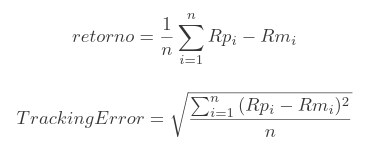

Em que:
> *Rpi* é o retorno do portfólio para o mês *i*;

> *Rmi* é o retorno do benchmark para o mês *i*;

> *n* é o número total de meses.

Sabendo disso, podemos calcular o *Information Ratio* das nossas carteiras.

In [ ]:
def retorno_IR(portfolio, benchmark):
  return mean(portfolio - benchmark)
  
def tracking_error(portfolio, benchmark):
  return stdev(portfolio - benchmark)

def information_ratio(portfolio, benchmark):
  return retorno_IR(portfolio, benchmark) / tracking_error(portfolio, benchmark)

In [ ]:
#Portfólio sem aportes
retornos_portfolio = patrimonio["retornos"].values
retornos_benchmark = Rm

inf_ratio = information_ratio(retornos_portfolio, retornos_benchmark)
print(f"O Information Ratio da carteira sem aportes foi de {inf_ratio:.3f}; com retorno = {retorno_IR(retornos_portfolio, retornos_benchmark):.3f} e tracking_error = {tracking_error(retornos_portfolio, retornos_benchmark):.3f}")

#Portfólio com aportes
retornos_portfolio = patrimonio_com_aportes["retornos"].values
retornos_benchmark = Rm

inf_ratio = information_ratio(retornos_portfolio, retornos_benchmark)
print(f"O Information Ratio da carteira sem aportes foi de {inf_ratio:.3f}; com retorno = {retorno_IR(retornos_portfolio, retornos_benchmark):.3f} e tracking_error = {tracking_error(retornos_portfolio, retornos_benchmark):.3f}")

O Information Ratio da carteira sem aportes foi de -0.079; com retorno = -0.001 e tracking_error = 0.016
O Information Ratio da carteira sem aportes foi de 0.431; com retorno = 0.009 e tracking_error = 0.022


# Retorno Anormal: Alfa de Jensen

O Alfa de Jensen (**α**) é uma medida de retorno anormal, ou seja, parte do retorno do portfólio não explicado pelo risco assumido (medido pelo beta do portfólio - ver [Calculando o Beta em Python](https://tc.com.br/tc-school/quant-investimentos/python-calcular-beta/)). 

O **α** é o coeficiente linear do modelo CAPM - discutido em [Python: Modelo de Precificação de Ativos (CAPM)](https://tc.com.br/tc-school/quant-investimentos/python-capm/) - o qual é utilizado para estimar o retorno teórico esperado de um portfólio [9]. Para encontrar esse valor, devemos realizar a regressão linear dos excessos de retorno da carteira com os do benchmark.

E[Rp] - Rf = α + β(E[Rm] -Rf) [9]

Em que, 
* E[Rp] - Rf representa os excessos de retorno do portfólio;
* E[Rm] - Rf representa os excessos de retorno do mercado.
* α - significa o retorno anormal do portfólio (Alfa de Jensen)
* β - significa o beta do portfólio

Com isso, podemos aplicar a função *OLS* da biblioteca *statsmodels* - que realiza uma regressão linear utilizando o método dos Mínimos Quadrados Ordinários - nos dados dos retornos das carteiras e do Ibovespa para descobrirmos o beta e o alfa dos portfólios.

In [ ]:
#Portfólio sem aportes
excessos_retornos_mercado = add_constant(np.array(Rm) - np.array(selic)) #adiciona constante para calcular o alfa
excessos_retornos_carteira = np.array(patrimonio["retornos"]) - np.array(selic)

model1 = OLS(excessos_retornos_carteira, excessos_retornos_mercado ).fit()
print("-"*35 + "Portfólio sem aportes" + "-"*35 + "\n\n")
print(model1.summary())
print("\n")


#Portfólio com aportes
excessos_retornos_mercado = add_constant(np.array(Rm) - np.array(selic))
excessos_retornos_carteira = np.array(patrimonio_com_aportes["retornos"]) - np.array(selic)

model2 = OLS(excessos_retornos_carteira, excessos_retornos_mercado ).fit()
print("-"*35 + "Portfólio com aportes" + "-"*35 + "\n\n")
print(model2.summary())

-----------------------------------Portfólio sem aportes-----------------------------------


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     205.8
Date:                Thu, 18 Mar 2021   Prob (F-statistic):           5.36e-08
Time:                        17:27:07   Log-Likelihood:                 33.563
No. Observations:                  12   AIC:                            -63.13
Df Residuals:                      10   BIC:                            -62.16
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


Para tais resultados das regressões, obtemos os seguintes modelos para os portfólios:

In [ ]:
print(f"Portfólio sem aporte:  α = {model1.params[0]*100:.2f}% ao mês")
print(f"Portfólio com aporte:  α = {model2.params[0]*100:.2f}% ao mês")

Portfólio sem aporte:  α = -0.02% ao mês
Portfólio com aporte:  α = 0.84% ao mês


#Conclusão

Neste artigo aprendemos a calcular os retornos periódicos e acumulados para carteiras com e sem aportes mensais e ajustá-los ao risco utilizando 3 métricas: risco-retorno, Índice de Sharpe e Índice de Treynor. Além disso, aprendemos a avaliar o desempenho do portfólio com base em um benchmark, calculando retornos relativos. Por fim, revisamos o CAPM para calcular o retorno anormal (**α**) do portfólio.

#Referências

[CFA Institute Investment Foundations®, Third Edition - Chapter 19](https://www.cfainstitute.org/-/media/documents/support/programs/investment-foundations/19-performance-evaluation.ashx?la=en&hash=F7FF3085AAFADE241B73403142AAE0BB1250B311)

[TC School - Calculando o Beta em Python](https://tc.com.br/tc-school/quant-investimentos/python-calcular-beta/)

[TC School - Python: Modelo de Precificação de Ativos (CAPM)](https://tc.com.br/tc-school/quant-investimentos/python-capm/)

#Link para Notebook

[Google Colaboratory](http://bit.ly/TC-avalia-performance)

#Autor

Vítor Diniz

Estagiário do TC Matrix

Graduando em Ciência da Computação pela Universidade Federal de Campina Grande (UFCG)